In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import tifffile
import cv2
import os
from patchify import patchify  #Only to handle large images
import random
# from scipy import ndimage

In [2]:
from  pycocotools.coco import COCO

In [3]:
coco = COCO('/media/wlli/T7/data/for_sam_test/100x_bin1x1_2040x2040_DV_WT_02.json')
image = cv2.imread("/media/wlli/T7/data/for_sam_test/100x_bin1x1_2040x2040_DV_WT_02.png", -1)
masks = []
for i in coco.anns.keys():
    masks.append(coco.annToMask(coco.anns[i]))
masks = np.array(masks)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
large_images = np.zeros(masks.shape, dtype=np.uint8)
large_masks = masks*255
for i in range(0, masks.shape[0]):
    large_images[i] = image

In [5]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 128

In [6]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 1).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [7]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (424, 256, 256)
Mask shape: (424, 256, 256)


In [8]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# # Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

/home/wlli/miniconda3/envs/sam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 424
})

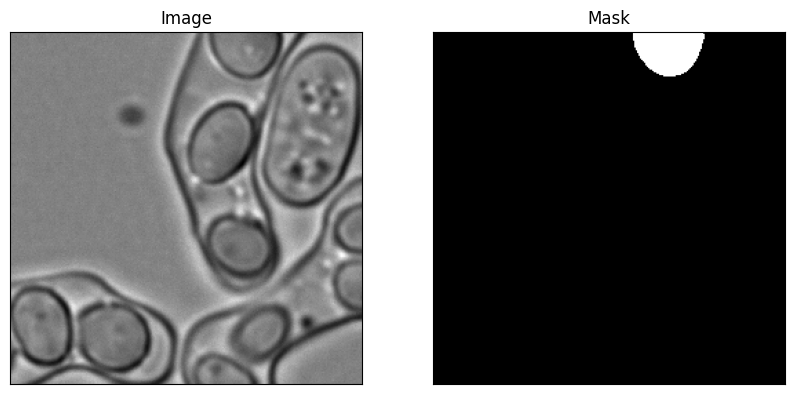

In [10]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [176]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    return bbox

def get_points(ground_truth_map, n=1, patch=1):
    # get bounding box from mask
    points = []
    labels = []
    for j in range(0, patch):
        point = []
        label = []
        y_indices, x_indices = np.where(ground_truth_map > 0)
        index = np.random.randint(0, len(x_indices), n)
        for i in index:
            point.append([x_indices[i], y_indices[i]])
            label.append([1])
        points.append(point)
        labels.append(label)
    return points, labels
    # return bbox

In [201]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt_bbox = get_bounding_box(ground_truth_mask)
    print(prompt_bbox)
    prompt_point = get_points(ground_truth_mask, n=1, patch=10)
    print(prompt_point)
    # prepare image and prompt for the model
    #self.processor.set_image(image)
    inputs = self.processor(image,
                            # input_boxes=[[prompt]],
                            input_points = [prompt_point[0]],
                            input_labels = prompt_point[1],
                            return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [202]:
prompt_point = get_points(large_masks[0], n=2, patch=3)

In [203]:
np.array(prompt_point[0])

array([[[ 992,  623],
        [ 960,  652]],

       [[ 925,  654],
        [ 929,  656]],

       [[1070,  662],
        [ 992,  617]]])

In [204]:
a

[[[1], [1]], [[1], [1]], [[1], [1]]]

In [205]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [206]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [207]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

[128, 202, 255, 256]
([[[199, 240]], [[236, 231]], [[226, 241]], [[224, 231]], [[155, 236]], [[207, 236]], [[232, 240]], [[195, 223]], [[164, 233]], [[221, 254]]], [[[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]]])
pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([10, 1, 2])
input_labels torch.Size([10, 1, 1])
ground_truth_mask (256, 256)


In [208]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [209]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

[25, 59, 94, 124]
([[[47, 105]], [[42, 106]], [[44, 96]], [[48, 78]], [[58, 76]], [[63, 116]], [[77, 89]], [[76, 99]], [[61, 103]], [[46, 103]]], [[[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]]])
[225, 6, 256, 62]
([[[254, 57]], [[245, 29]], [[253, 51]], [[255, 56]], [[252, 30]], [[255, 39]], [[255, 36]], [[243, 53]], [[246, 44]], [[243, 29]]], [[[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]]])
pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_points torch.Size([2, 10, 1, 2])
input_labels torch.Size([2, 10, 1, 1])
ground_truth_mask torch.Size([2, 256, 256])


In [210]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [211]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-huge")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [212]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [213]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_points=batch["input_points"].to(device),
                      input_labels=batch["input_labels"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())
      print(f'EPOCH: {epoch}')
      print(f'Mean loss: {mean(epoch_losses)}')

print(f'EPOCH: {epoch}')
print(f'Mean loss: {mean(epoch_losses)}')

  0%|                                                   | 0/212 [00:00<?, ?it/s]

[104, 4, 165, 68]
([[[132, 56]], [[147, 33]], [[127, 53]], [[135, 36]], [[119, 39]], [[123, 24]], [[115, 31]], [[118, 57]], [[114, 48]], [[126, 45]]], [[[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]]])
[178, 157, 256, 256]
([[[201, 182]], [[221, 177]], [[228, 206]], [[233, 220]], [[230, 231]], [[200, 214]], [[221, 174]], [[201, 249]], [[243, 203]], [[230, 180]]], [[[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]], [[1]]])


  0%|                                                   | 0/212 [00:23<?, ?it/s]


KeyboardInterrupt: 

In [111]:
torch.save(model.state_dict(), "/home/wlli/Data/mito_model_checkpoint.pth")

In [112]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [113]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-huge")
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")


# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/home/wlli/Data/mito_model_checkpoint.pth"))

<All keys matched successfully>

In [22]:
aaa = torch.load("/home/wlli/Data/mito_model_checkpoint.pth")

In [23]:
bbb = torch.load("../models/sam_vit_h_4b8939.pth")

In [24]:
KEYS_TO_MODIFY_MAPPING = {
    "iou_prediction_head.layers.0": "iou_prediction_head.proj_in",
    "iou_prediction_head.layers.1": "iou_prediction_head.layers.0",
    "iou_prediction_head.layers.2": "iou_prediction_head.proj_out",
    "mask_decoder.output_upscaling.0": "mask_decoder.upscale_conv1",
    "mask_decoder.output_upscaling.1": "mask_decoder.upscale_layer_norm",
    "mask_decoder.output_upscaling.3": "mask_decoder.upscale_conv2",
    "mask_downscaling.0": "mask_embed.conv1",
    "mask_downscaling.1": "mask_embed.layer_norm1",
    "mask_downscaling.3": "mask_embed.conv2",
    "mask_downscaling.4": "mask_embed.layer_norm2",
    "mask_downscaling.6": "mask_embed.conv3",
    "point_embeddings": "point_embed",
    "pe_layer.positional_encoding_gaussian_matrix": "shared_embedding.positional_embedding",
    "image_encoder": "vision_encoder",
    "neck.0": "neck.conv1",
    "neck.1": "neck.layer_norm1",
    "neck.2": "neck.conv2",
    "neck.3": "neck.layer_norm2",
    "patch_embed.proj": "patch_embed.projection",
    ".norm": ".layer_norm",
    "blocks": "layers",
}

In [29]:
import re
import copy

state_dict = bbb
model_state_dict = aaa
to_old_name_dict = {}
state_dict.pop("pixel_mean", None)
state_dict.pop("pixel_std", None)

output_hypernetworks_mlps_pattern = r".*.output_hypernetworks_mlps.(\d+).layers.(\d+).*"

for key, value in state_dict.items():
    m_key = copy.copy(key)
    for key_to_modify, new_key in KEYS_TO_MODIFY_MAPPING.items():
        if key_to_modify in key:
            m_key= m_key.replace(key_to_modify, new_key)
    if re.match(output_hypernetworks_mlps_pattern, m_key):
        layer_nb = int(re.match(output_hypernetworks_mlps_pattern, m_key).group(2))
        if layer_nb == 0:
            m_key = m_key.replace("layers.0", "proj_in")
        elif layer_nb == 1:
            m_key = m_key.replace("layers.1", "layers.0")
        elif layer_nb == 2:
            m_key = m_key.replace("layers.2", "proj_out")

    to_old_name_dict[key] = model_state_dict[m_key]

In [33]:
to_old_name_dict.keys() == bbb.keys()

True

In [35]:
torch.save(to_old_name_dict, "/home/wlli/Data/mito_model_checkpoint_oldname.pth")

In [114]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-31): 32 x SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (layer_norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNor

In [115]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Mask')

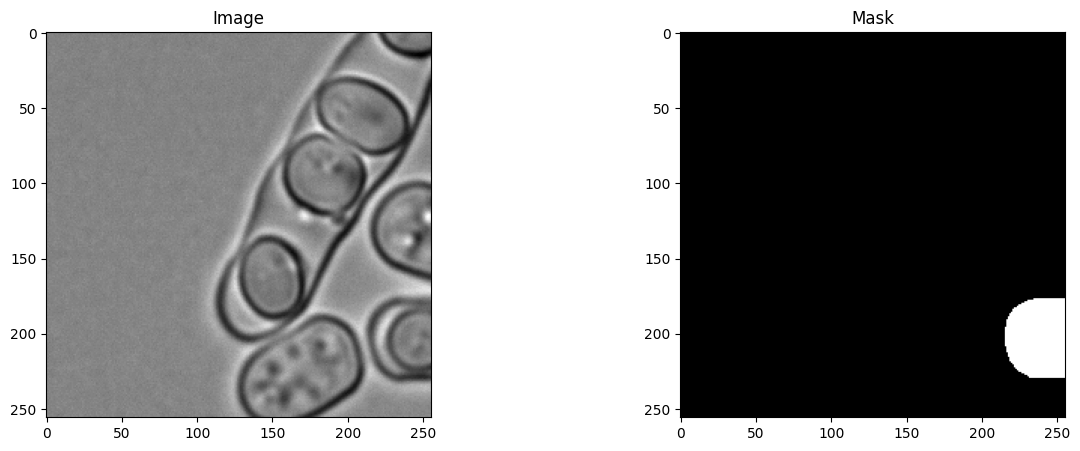

In [117]:
idx = 62
test_image = dataset[idx]["image"]
test_mask = dataset[idx]["label"]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(test_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

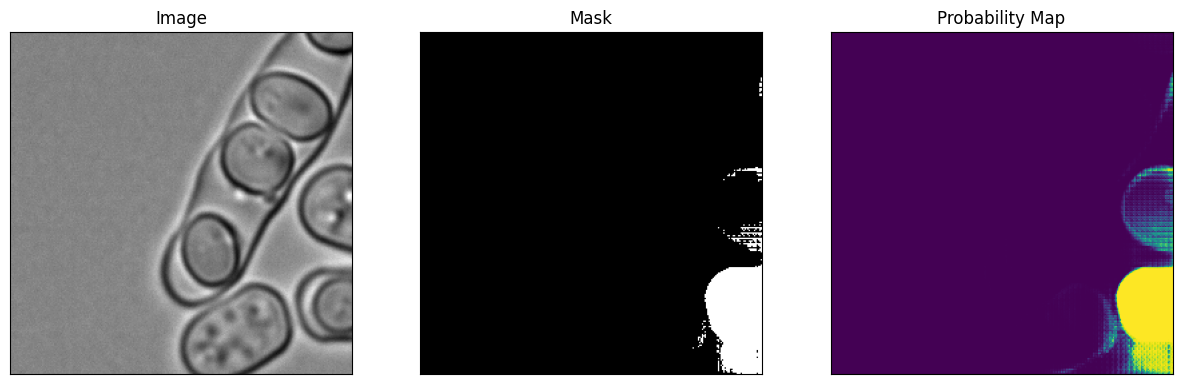

In [120]:
# let's take a random training example
idx = 62#random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
